# CE 5362 Lesson 9 Unsteady Open Channel Flow
---

Refining the Lax-Scheme to generalize and explore some different examples.

## Finite-Difference Method for Unsteady Open Channel Flow

 The simplest form of solution that is conditionally stable and reasonably straightforward to program is called the Lax-Diffusion scheme.  Recall our difference equations derived from continunity:

\begin{equation}
\begin{matrix}
y_i^{t+\Delta t} = \frac{1}{2}(y_{i-1}^t+y_{i+1}^t) -\frac{r}{2}(\frac{A}{B}\vert_{i-1}^t + \frac{A}{B}\vert_{i+1}^t)(V_{i+1}^{t}-V_{i-1}^t)-\frac{r}{2}(V_{f,i-1}^t + V_{f,i+1}^t)(y_{i+1}^{t}-y_{i-1}^t) \\
~\\
 \end{matrix}
 \label{eqn:lax-continunity}
\end{equation}


and momentum:

\begin{equation}
\begin{matrix}
V_i^{t+\Delta t}=\frac{1}{2}(V_{i-1}^t+V_{i+1}^t) +
\Delta t  g(S_0-\frac{1}{2}(S_{f,i-1}^t + S_{f,i+1}^t))
- \frac{r}{2}(V_{i-1}^t+V_{i+1}^t) (V_{i+1}^{t}-V_{i-1}^t)
-rg(y_{i+1}^{t}-y_{i-1}^t)\\
~\\
\end{matrix}
\label{eqn:lax-momentum}
\end{equation}

### Example Non-Prismatic Channel - Still a Steady Flow Case
A plan view of a rectangular channel of variable width as shown in Figure 1


![](NonPrismaticExample1.jpg)

|Figure 1. Non-Prismatic Rectangular Channel|
|---|

The channel conveys $Q=100~m^3/sec$, with a bottom slope of $0.001$ and average Manning's $n$ value of $0.033$.  A backwater curve is caused by a weir at the downstream end (to the right in the figure) by a 7 meter tall weir.
Flow depth over the weir is at critical depth $h_c = 2.17$ meters.  Normal flow in the upstream portion for 10-meter channel width is $h_n = 5.6$ meters.  Using the unsteady solver, run the solver until an equilibrium solution is returned and compare the result to either the same case in the fixed-step steady flow solver, or SWMM.

As with our prior example, we will just modify our script a bit to handle the changing geometry. In this example we will place the script into three sub-blocks to facilitate changes and re-running after those changes.

In [259]:
import math # python package for various common math functions
import matplotlib # python plotting package

########## prototype hydraulic functions #####################
# hydraulic functions for trapezoidal channels
# depth == flow depth          
# bottom == bottom width of trapezoidal channel
# side == side slope (same value both sides) of trapezoidal channel
# computed values:
# bt == computed topwidth :: ar == flow area, used in fd update :: wp == wetted perimeter, used in fd update

def bt(depth,bottom,side):   # depth-topwidth function
    topwidth = (bottom + 2.0*side*depth);
    return(topwidth);

def ar(depth,bottom,side):  # depth area function
    area = (depth*(bottom+side*depth));
    return(area)

def wp(depth,bottom,side):   # depth perimeter
    import math
    perimeter = (bottom+2.0*depth*math.sqrt(1.0+side*side));
    return(perimeter)

######### prototype display functions #########################

def writenow(t,dt,y,v,b0,s): # printing functions
    print("__________")
    print("Time = ",t," seconds.","Time step length = ",dt," seconds ")
    print("IROW "," DEPTH "," VELOCITY ")
    for irow in range(0,len(v)):
        print(irow,round(y[irow],3),round(v[irow],3))
    return()  #observe a NULL return, this function messages to the output device, so there is nothing to return.

def plot2lines(list1,list2,list3,list4,strx,stry,strtitle): # plot list1 on x, list2 on y, xlabel, ylabel, title
    from matplotlib import pyplot as plt # import the plotting library from matplotlibplt.show()
    myfigure = matplotlib.pyplot.figure(figsize = (16,8))
    plt.plot( list1, list2, color ='brown', marker ='', linestyle ='solid') # create a line chart, years on x-axis, gdp on y-axis
    plt.plot( list3, list4, color ='blue', marker ='', linestyle ='solid') # create a line chart, years on x-axis, gdp on y-axis
    plt.title(strtitle)# add a title
    plt.ylabel(stry)# add a label to the x and y-axes
    plt.xlabel(strx)
    plt.show() # display the plot
    return #null return

Our problem constants are modified in this instance as in the fragment below, this block is mostly input conditions and some prerptory calculations before the hydraulics model -- observe how we have added vecotrs for geometry in this case.

In [260]:
###### Problem Constants and Input Block #######
# simulation domain
l = 30000.0 # total length (the length of computational domain)
n = 30 # number of reaches
# physical constants
g = 9.81 # gravitational acceleration, obviously SI units

q0 = 100.0 # initial discharge
yd = 9.17 # initial flow depth in the model
yu = 5.60 # upstream constant depth
mn = 0.033 # Manning's n
s0 = 0.001 # longitudinal slope (along direction of flow)

tmax = 86000 # total simulation time in seconds (one day in this case)
iprt =  1000 # print every iprt time steps (make big to suppress output)
nn = n+1 # how many nodes, will jack with boundaries later
mn2 = mn*mn # Manning's n squared, will appear a lot.
######## Here we build storage vectors ###############
bw = [0]*nn # bottom width vector 
ss = [0]*nn # side slope vector
#### Geometry
bw = [10,10,10,10,10,10,10,10,10,10,10,10,9,8,7,9,8,7,8,9,10,11,12,13,14,13,12,11,10,10,10]
ss = [0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0]
#### Initial Velocity 
a = ar(yd,bw[n],ss[n]) # flow area at beginning of time
v0 = q0/a # initial velocity
#### depth and velocity vectors
y = [0]*nn # create nn elements of vector y, all zero
yp = [0]*nn # updates go in this vector, same length as y
v = [0]*nn # create nn elements of vector v
vp = [0]*nn # updates go in this vector, same length and v
ytmp = [0]*nn
vtmp = [0]*nn
y = [float(yd) for i in y] # populate y with nn things, each thing has value yd
v = [float(v0) for i in y] # populate v with nn things, each thing has value v0
### Build the output geometry
b = bt(y[n],bw[n],ss[n]) # topwidth at downstream end
c = math.sqrt(g*a/b) # celerity at initial conditions
dx = l/n # delta x, length of a reach
xx = [dx*(i) for i in range(0,nn)] # Spatial locations of nodes, used for plotting
bse = [30 - s0*xx[i] for i in range(0,nn)] # bottom channel elevation
wse = [bse[i]+y[i] for i in range(0,nn)] # water surface elevation
dt = dx/(v0 + c) # the time step that satisfies the courant condtions
kmax = round(tmax/dt)  # set maximum number of time steps
print('Celerity = ',round(c,3) )
print('Delta x  = ',round(dx,3))
print('Delta t  = ',round(dt,3))
print("ITmax = ",(kmax))

Celerity =  9.485
Delta x  =  1000.0
Delta t  =  94.562
ITmax =  909


__________
Time =  0.0  seconds. Time step length =  94.56161179137669  seconds 
IROW   DEPTH   VELOCITY 
0 9.17 1.091
1 9.17 1.091
2 9.17 1.091
3 9.17 1.091
4 9.17 1.091
5 9.17 1.091
6 9.17 1.091
7 9.17 1.091
8 9.17 1.091
9 9.17 1.091
10 9.17 1.091
11 9.17 1.091
12 9.17 1.091
13 9.17 1.091
14 9.17 1.091
15 9.17 1.091
16 9.17 1.091
17 9.17 1.091
18 9.17 1.091
19 9.17 1.091
20 9.17 1.091
21 9.17 1.091
22 9.17 1.091
23 9.17 1.091
24 9.17 1.091
25 9.17 1.091
26 9.17 1.091
27 9.17 1.091
28 9.17 1.091
29 9.17 1.091
30 9.17 1.091
__________
Time =  83063.06950202376  seconds. Time step length =  184.4376617037278  seconds 
IROW   DEPTH   VELOCITY 
0 5.6 1.824
1 5.606 1.825
2 5.614 1.824
3 5.625 1.823
4 5.638 1.822
5 5.655 1.82
6 5.675 1.818
7 5.702 1.815
8 5.734 1.812
9 5.775 1.806
10 5.827 1.805
11 5.882 1.778
12 5.932 1.764
13 5.944 1.69
14 5.952 1.751
15 5.952 1.673
16 5.924 1.71
17 5.918 1.721
18 5.904 1.701
19 5.906 1.754
20 5.961 1.782
21 6.068 1.799
22 6.233 1.805
23 6.463 1.799
24 6.

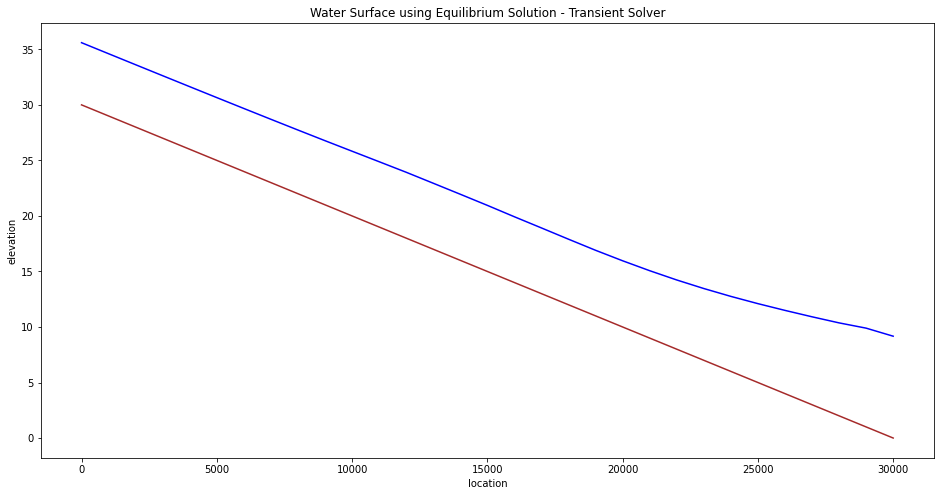

In [261]:
k = 0 # time counter
t = 0.0 # elapsed time
writenow(t,dt,y,v,b0,s) #print the start conditions
for itime in range(0,kmax): # begin time stepping loop scope
#print('Iteration Count = ',itime)
######## Adaptive Time Step Based on Current mesh courant number ###
    bestdt = dt # start with current time step
### begin courant number each cell loop scope
    for i in range(0,nn):
        a = ar(y[i],bw[i],ss[i]);
        b = bt(y[i],bw[i],ss[i]);
        c = math.sqrt(g*a/b);
        dtn = dx/abs((v[i])+c)
    # now test
        if(dtn < bestdt):
            bestdt = dtn
### end courant number each cell loop scope
    dt = bestdt
#print('time-step length = ',dt)
#writenow(t,dt,y,v,b0,s)


###### Finite Difference #################################
    r = 0.5*dt/dx;
###### LEFT BOUNDARY #####################################
# UPSTREAM FIXED STAGE AT PRESCRIBED NORMAL DEPTH        #
##########################################################
    yp[0] = yu
    ab = ar(y[1],bw[1],ss[1]);
    bb = bt(y[1],bw[1],ss[1]);
    cb = math.sqrt(g*bb/ab);
    rb = ab/wp(y[1],bw[1],ss[1]);
    sfb = (mn2*v[1]*v[1])/(rb**(1.333));
    cn = v[1] -cb*y[1]+ g*(s0-sfb)*dt;
    vp[0] = cn + cb*yp[0];
###### RIGHT BOUNDARY ####################################
#         FIXED STAGE AT DOWNSTREAM END                  #
##########################################################
# reflection boundary, find velocity along a characteristic
    yp[n-1] = yd ;
    aa = ar(y[n-1],bw[n-1],ss[n-1]);
    ba = bt(y[n-1],bw[n-1],ss[n-1]);
    ca = math.sqrt(g*ba/aa);
    ra = aa/wp(y[n-1],bw[n-1],ss[n-1]);
    sfa = (mn2*v[n-1]*v[n-1])/(ra**(4.0/3.0));
    cp = v[n-1] + ca*y[n-1]+g*(s0-sfa)*dt;
##yp[nn] <<- (cp - vp[nn])/ca;
    vp[n] = cp - yp[n]*ca 
######## INTERIOR NODES AND REACHES ###############
### loop through the interior nodes
    for i in range(1,n): # begin interior node loop scope
        aa = ar(y[i-1],bw[i-1],ss[i-1]);
        ba = bt(y[i-1],bw[i-1],ss[i-1]);
        pa = wp(y[i-1],bw[i-1],ss[i-1]);
        ra = aa/pa;
        sfa = (mn2*v[i-1]*v[i-1])/(ra**(4.0/3.0));
        ab = ar(y[i+1],bw[i+1],ss[i+1]);
        bb = bt(y[i+1],bw[i+1],ss[i+1]);
        pb = wp(y[i+1],bw[i+1],ss[i+1]);
        rb = ab/pb;
        sfb = (mn2*v[i+1]*v[i+1])/(rb**(4.0/3.0));
# need averages of sf, hydraulic depth
        dm = 0.5*(aa/ba + ab/bb);
        sfm = 0.5*(sfa+sfb);
        vm = 0.5*(v[i-1]+v[i+1]);
        ym = 0.5*(y[i-1]+y[i+1]);
# new momentum
        vp[i] = vm -r*g*(y[i+1] - y[i-1]) -r*vm*(v[i+1] - v[i-1]) + g*dt*(s0-sfm);
# new depth
        yp[i] = ym - r*dm*(v[i+1] - v[i-1]) -r*vm*(y[i+1] - y[i-1]);
### end of interior node loop scope
# update time, count, depth and momentum
    t = t+dt; # Increment simulation time
    k = k+1; # Increment loop counter
    for i in range(0,n):
        v[i]=vp[i]
        y[i]=yp[i]
    if (k%iprt == 0): # Write current conditions every iprt time steps
        writenow(t,dt,y,v,b0,s)
    dt = 2*dt #artificially inflate the time step to force adaptive update
# end time step loop

# provisional code to make a plot
writenow(t,dt,y,v,b0,s)
for i in range(0,nn):
    wse[i]=bse[i]+y[i]
plot2lines(xx,bse,xx,wse,"location","elevation","Water Surface using Equilibrium Solution - Transient Solver")

In [273]:
# copy from lesson 6
depth_steady_solver = [9.17,8.459000000000003,7.813,7.206000000000003,6.584,5.969,5.379000000000002,4.889,4.665,4.701,4.931999999999999,5.306000000000003,5.810000000000002,6.467000000000001,6.9,6.819000000000002,6.532,6.202000000000002,5.960000000000001,5.791999999999998,5.681999999999999,5.612,5.568000000000001,5.5409999999999995,5.525000000000001,5.5150000000000015,5.509000000000003,5.506000000000002,5.504000000000001,5.502000000000001,  5.502000000000001]
depth_unsteady_solver = [0]*nn
for i in range(n,-1,-1):
    depth_unsteady_solver[i] = y[n-i]
difference = []
for i in range(len(y)):
    difference.append(100*(depth_steady_solver[i]-depth_unsteady_solver[i])/depth_steady_solver[i])

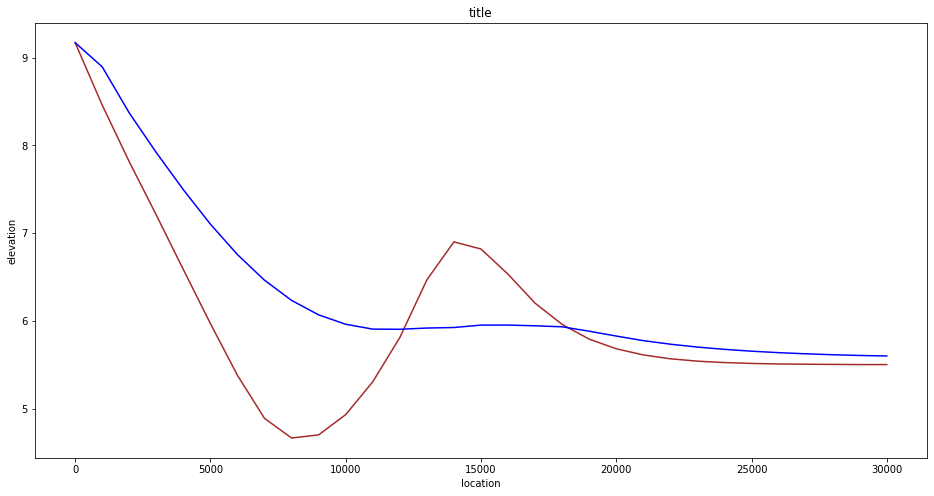

In [274]:
plot2lines(xx,depth_steady_solver,xx,depth_unsteady_solver,"location","elevation","title")

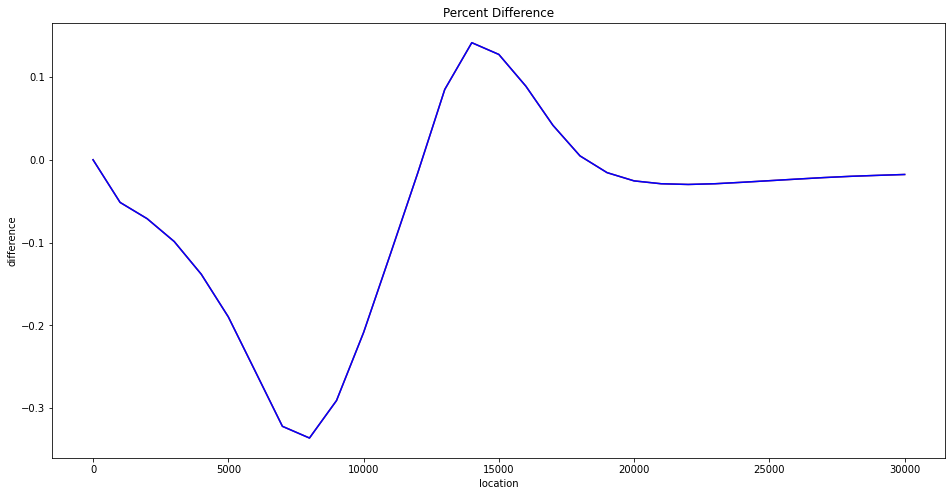

In [276]:
plot2lines(xx,difference,xx,difference,"location","difference","Percent Difference")

## Building a Tool

The script is comprised of several parts, and eventually for the sake of taking advantage of the ability to read and operate on files, the script will have several "libraries" that are read by a main control program.  

The main program controls the overall solution process, while the library functions can be built and tested in advance.  What follows is a port from an old FORTRAN and later R program that is specific to this problem, we will get it working first, then generalize for reuse.



The next set of functions are prototype functions for reporting the output -- it will be cleaner to build the output functions separate from the control program, and send the necessary vectors when we want to actually print results.